In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

In [2]:
with open("thoma_baseline.json") as f:
    data = json.load(f)

# 0 action

In [3]:
# get action event

list_of_action = []

for v in data["debug"]:
    
    if v["event"] == "action":
        the_point = {
            'frame': v['frame'],
            'char_index': v['char_index'],
        }
        
        try:
            the_point['action'] = v["logs"]['action']
            list_of_action.append(the_point)                
        except Exception: 
            pass
        
    if v["frame"] > 1 * 1272:
        break

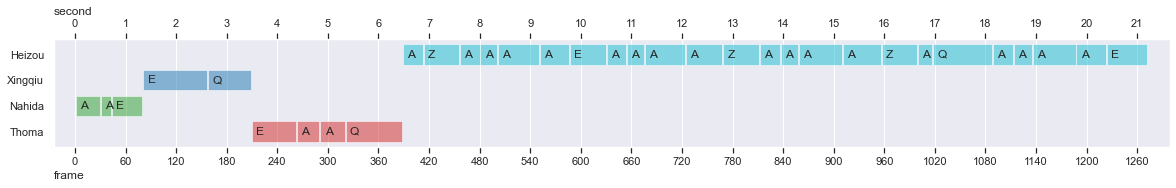

In [4]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(20,2))

the_gap = 1
the_colors = ["red", "green", "blue", "cyan"]
change_action_name = {
    "attack": "A",
    "charge": "Z",
    "skill": "E",
    "burst": "Q",
}

for idx in range(len(list_of_action)):
    
    if list_of_action[idx]["action"] == "swap":
        continue
    
    ax.broken_barh(
        xranges=[
            (list_of_action[idx]["frame"], list_of_action[idx+1]["frame"] - list_of_action[idx]["frame"] - the_gap)
        ], 
        yrange=(list_of_action[idx]["char_index"]+0.1, 0.8), 
        facecolors='tab:%s'%the_colors[list_of_action[idx]["char_index"]], 
        alpha=0.5)
    
    ax.annotate(
        change_action_name[list_of_action[idx]["action"]], 
        xy=(list_of_action[idx]["frame"]+5*the_gap, list_of_action[idx]["char_index"]+0.5), 
        annotation_clip=False, rotation=0, ha="left", va="center")
    
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_yticklabels(["Thoma", "Nahida", "Xingqiu", "Heizou",""])

ax.set_xticks(range(0,1300,60))

# set x/y range
the_ymax = 4
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
the_xmax = 1273
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)


ax1 = ax.twiny()
the_xmax1 = the_xmax/60
ax1.set_xlim(-the_xmax1*0.02, the_xmax1*1.02)

# same grid
ax1.set_xticks([ idx * the_xmax1 / the_xmax for idx in ax.get_xticks()])
ax1.grid(None)

ax.yaxis.grid(False)

ax.set_xlabel('frame', horizontalalignment='left', x=0)
ax1.set_xlabel('second', horizontalalignment='left', x=0)

plt.show()          

# 1 element

In [5]:
# get element event

debug_element = {}

for v in data["debug"]:
    
    if v["event"] == "element":
        
        the_target = v["logs"]["target"]
        the_key = "target: %d" % the_target
        
        if the_key not in debug_element:
            debug_element[the_key] = []
            
        debug_element[the_key].append(v)

In [6]:
def get_target_element_points(debug_element, the_target):
    
    the_gap = 0.0000000001

    list_of_points = []

    the_default_point = {

        "frame": 0,
        "abil": None,
        "dendro": 0,
        "hydro": 0,
        "pyro": 0,
        "burning": 0,
        "dendro (fuel)": 0
    }

    list_of_points.append(the_default_point)

    for v in debug_element["target: %d" % the_target]:  


        # get existing

        the_point = the_default_point.copy()
        the_point["frame"] = v["frame"]
        the_point["abil"] = v["logs"]["abil"]
        try:
            for ele in v["logs"]["existing"]:
                tmp = ele.split(': ')
                the_point[tmp[0]] = float(tmp[1])
                if tmp[0] == "burning": # special case: burning
                    the_point["dendro (fuel)"] = 0
                    the_point["burning"] = 0
        except Exception: 
            pass        
        list_of_points.append(the_point)

        # get after
        
        the_point = the_default_point.copy()
        the_point["frame"] = v["frame"] + the_gap

        try:
            for ele in v["logs"]["after"]:
                tmp = ele.split(': ')
                the_point[tmp[0]] = float(tmp[1])
        except Exception: 
            pass                    
        list_of_points.append(the_point)
        
    return list_of_points

In [7]:
def get_iteration_element_plot(list_of_points, the_itr):
    
    sns.set(style="darkgrid", palette="muted", color_codes=True)
    
    frame, dendro, hydro, pyro, burning, notation = [],[],[],[],[],[]    
    for v in list_of_points:
        frame.append(v['frame'])
        dendro.append(v['dendro'])
        hydro.append(v['hydro'])
        pyro.append(v['pyro'])
        burning.append(v['burning'])
        notation.append(v['abil'])

    the_length = 1272 
    
    fig = plt.figure(figsize=(60, 4))

    ax = fig.add_subplot(1,1,1)
    ax.set_title('Iteration %d' % the_itr)

    ax.plot(frame, dendro, color='green', label='dendro')
    ax.plot(frame, hydro, color='blue', label='hydro')
    ax.plot(frame, pyro, color='red', label='pyro')
    # ax.plot(frame, burning, color='black', label='burning')

    for i, txt in enumerate(notation):          
        if frame[i] > the_itr * the_length:
            break
        if frame[i] > (the_itr - 1) * the_length: 
            ax.annotate(txt, xy=(frame[i], -8), annotation_clip=False, rotation=90, ha="right", va="top")

    ax.set_xlim([(the_itr - 1) * the_length, 1 + the_itr * the_length])        
    ax.set_ylim([0, 50])  

    def frame2second(x):
        return x / 60

    def second2frame(x):
        return x * 60

    secax = ax.secondary_xaxis('top', functions=(frame2second, second2frame)) 

    ax.set_xlabel('frame', horizontalalignment='left', x=0)
    secax.set_xlabel('second', horizontalalignment='left', x=0)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(12))

    secax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    secax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))

    plt.legend()
    
    return fig

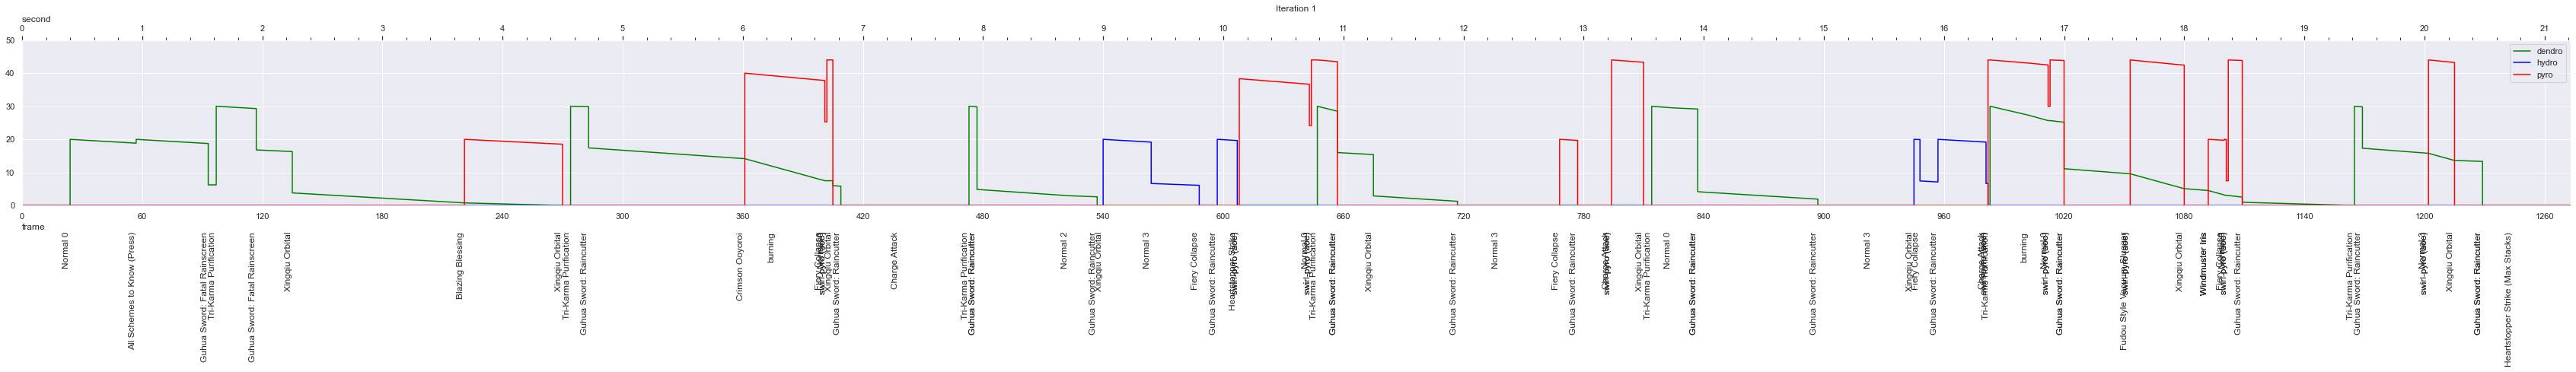

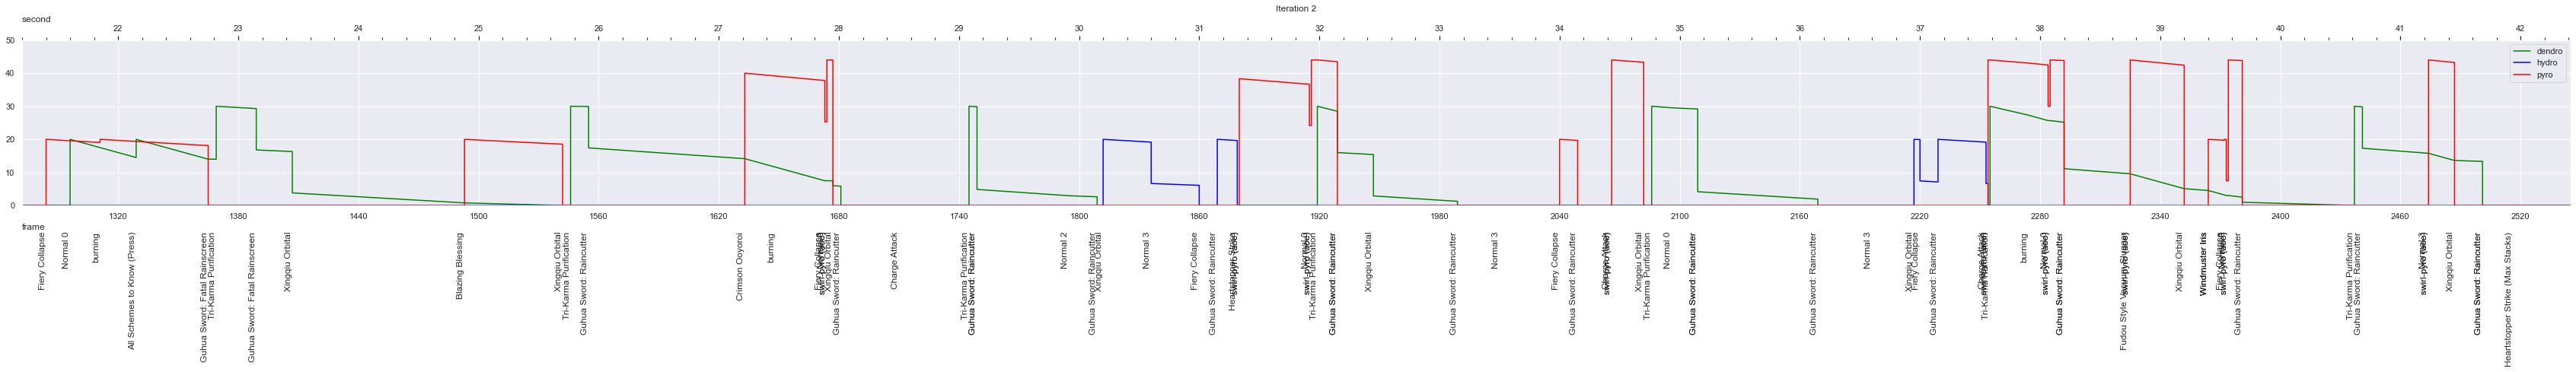

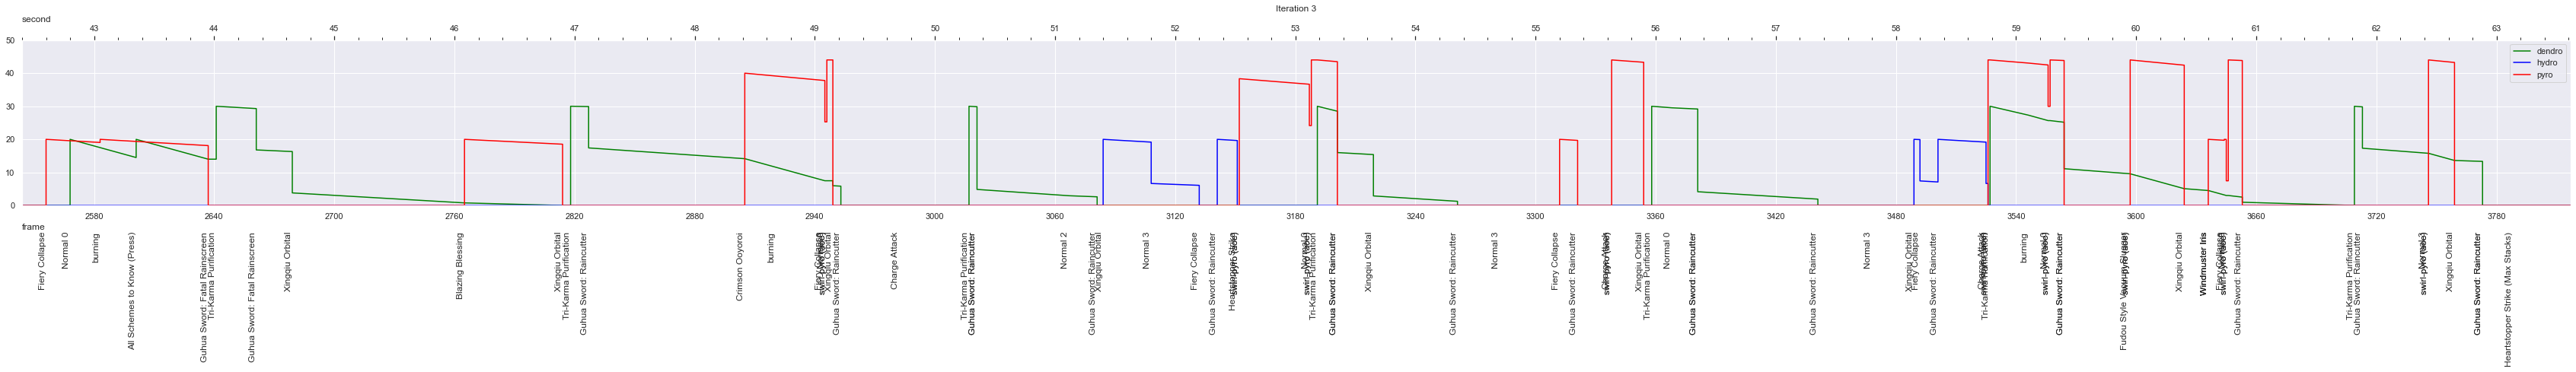

In [8]:
list_of_target1_element_points = get_target_element_points(debug_element = debug_element, the_target = 1)

fig_element_target1_iteration1 = get_iteration_element_plot(list_of_points = list_of_target1_element_points, the_itr = 1)
fig_element_target1_iteration2 = get_iteration_element_plot(list_of_points = list_of_target1_element_points, the_itr = 2)
fig_element_target1_iteration3 = get_iteration_element_plot(list_of_points = list_of_target1_element_points, the_itr = 3)

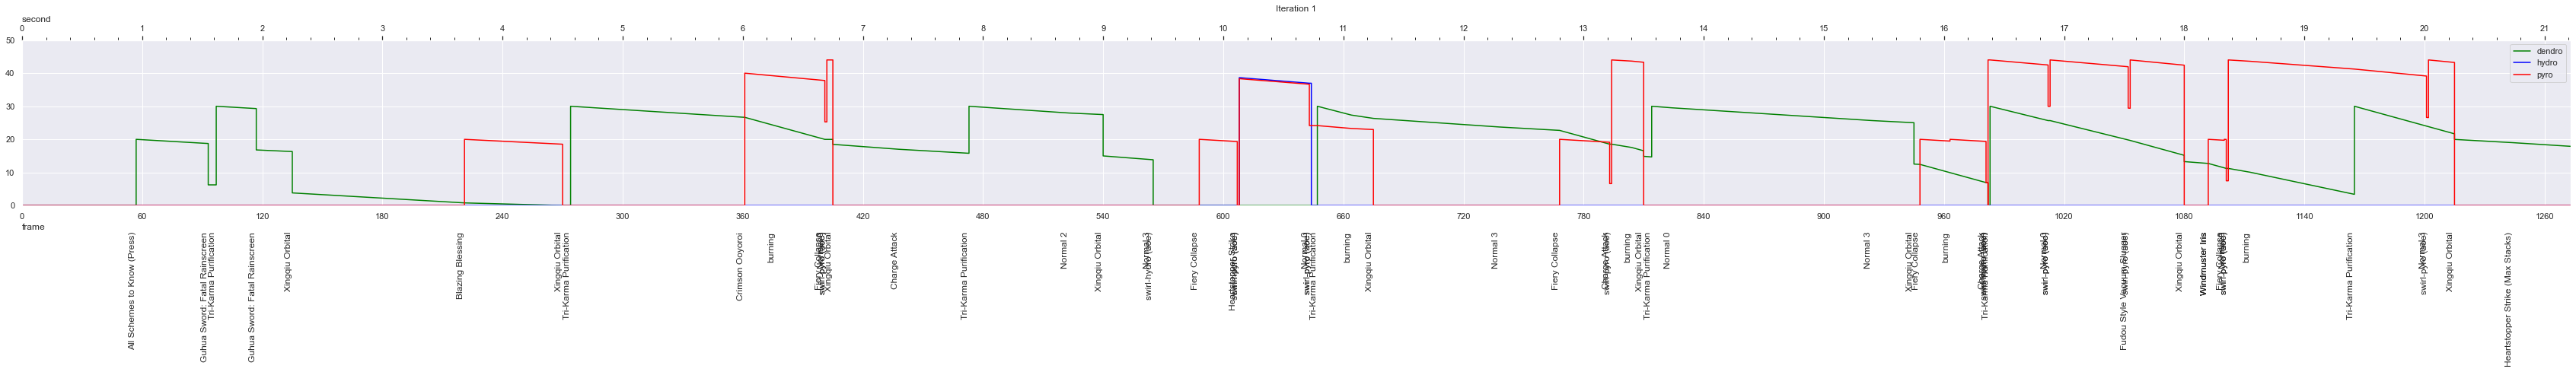

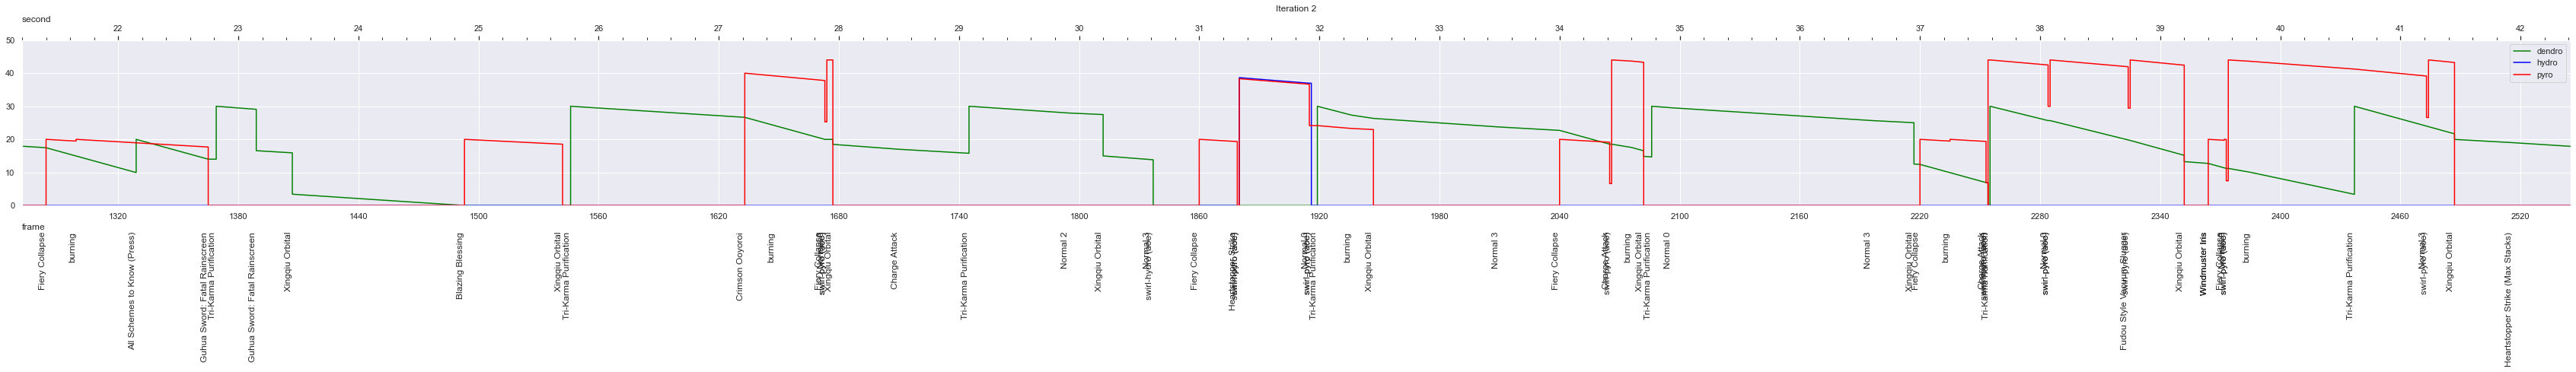

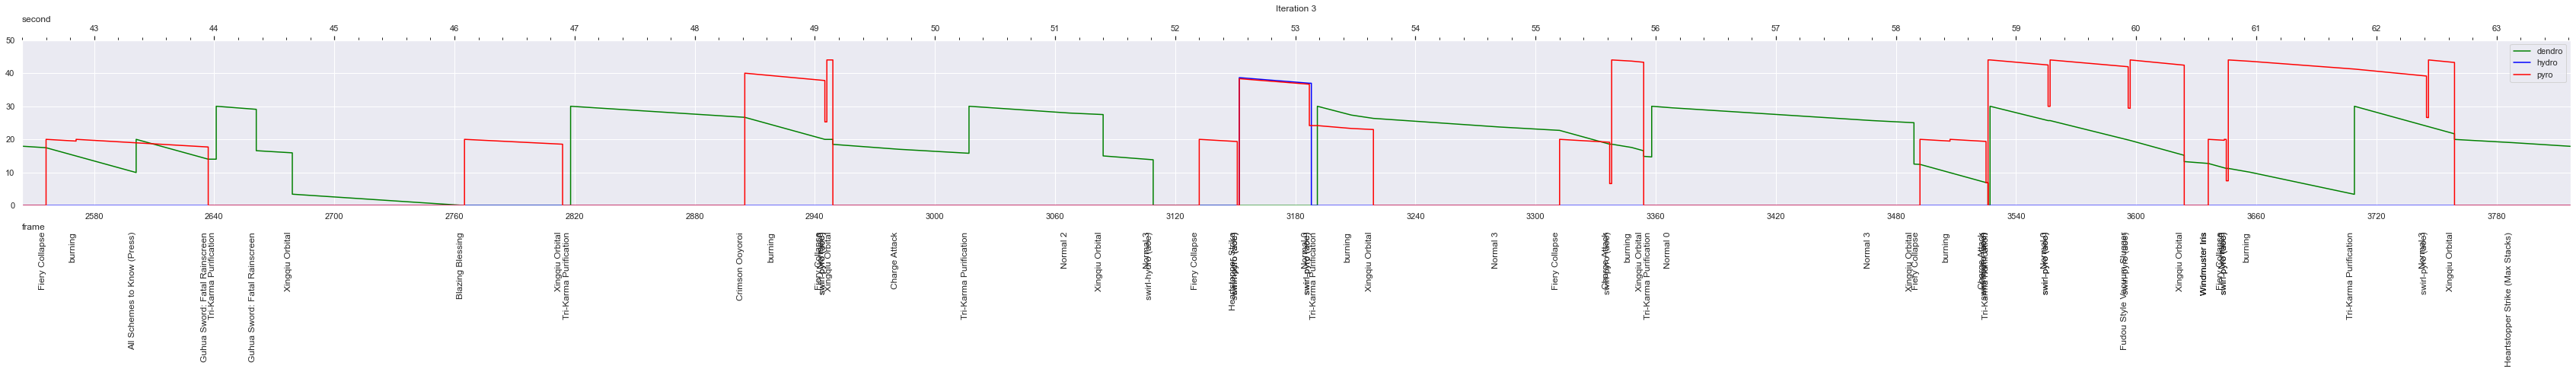

In [9]:
list_of_target2_element_points = get_target_element_points(debug_element = debug_element, the_target = 2)

fig_element_target2_iteration1 = get_iteration_element_plot(list_of_points = list_of_target2_element_points, the_itr = 1)
fig_element_target2_iteration2 = get_iteration_element_plot(list_of_points = list_of_target2_element_points, the_itr = 2)
fig_element_target2_iteration3 = get_iteration_element_plot(list_of_points = list_of_target2_element_points, the_itr = 3)

# 2  expected damage and hurt

In [10]:
 # get calc event

debug_calc = {}

for v in data["debug"]:

    if v["event"] == "calc":

        the_target = v["logs"]["target"]
        the_key = "target: %d" % the_target

        if the_key not in debug_calc: debug_calc[the_key] = []
        debug_calc[the_key].append(v)

In [11]:
for i in range(3):
    print(len(debug_calc["target: %d" % (i+1)]))

1984
1613
1613


In [12]:
 # get calc event

debug_damage = {}

for v in data["debug"]:

    if v["event"] == "damage":

        the_target = v["logs"]["target"]
        the_key = "target: %d" % the_target

        if the_key not in debug_damage:  debug_damage[the_key] = []
        debug_damage[the_key].append(v)

In [13]:
for i in range(3):
    print(len(debug_damage["target: %d" % (i+1)]))

1984
1613
1613


In [14]:
# cal expected damage

def get_target_expected_damage(the_target):

    the_default = {
        "char_index": 0,
        "frame": 0,
        "abil": 0,
        "expected_damage": 0,
        "target": 0
    }

    list_of_expected_damage = []

    for the_item in debug_calc["target: %d" % the_target]:

        tmp = the_default.copy()
        tmp["char_index"] = the_item['char_index']
        tmp["frame"] = the_item['frame']
        tmp["abil"] = the_item["logs"]['abil']
        tmp["target"] = the_target

        if (the_item["logs"]['damage'] == 0) or (the_item["logs"]['abil'] in ['bloom', 'burgeon']): 
            tmp["expected_damage"] = the_item["logs"]['damage']
        else:
            tmp["expected_damage"] = ( 
                the_item["logs"]['is_crit'] * the_item["logs"]['dmg_if_crit']  
                + (1-the_item["logs"]['is_crit']) * the_item["logs"]['pre_crit_dmg'] 
            ) * max(1, the_item["logs"]['amp_mult_total'])

        list_of_expected_damage.append(tmp)
        
    df_result = pd.DataFrame(list_of_expected_damage) 

    return df_result

In [15]:
df_expected_damage_target1 = get_target_expected_damage(the_target = 1)
df_expected_damage_target2 = get_target_expected_damage(the_target = 2)
df_expected_damage_target3 = get_target_expected_damage(the_target = 3)

In [16]:
df_expected_damage_target1["expected_damage"].sum() / df_expected_damage_target1["frame"].max() * 60

70317.33337197106

In [17]:
df_expected_damage_target2["expected_damage"].sum() / df_expected_damage_target2["frame"].max() * 60

59124.586564430305

In [18]:
df_expected_damage_target3["expected_damage"].sum() / df_expected_damage_target2["frame"].max() * 60

59551.704766924195

In [19]:
df_expected_damage_target1[ df_expected_damage_target1["abil"].isin(['bloom', 'burgeon']) ]

,char_index,frame,abil,expected_damage,target
7,2,138,bloom,4172.559214,1
8,2,156,bloom,4172.559214,1
9,2,156,bloom,0.000000,1
10,2,156,bloom,0.000000,1
12,0,222,burgeon,31417.271746,1
...,...,...,...,...,...
1947,3,12502,burgeon,22668.614608,1
1955,0,12549,burgeon,32618.826985,1
1956,0,12549,burgeon,32618.826985,1
1965,0,12609,burgeon,32618.826985,1


In [20]:
df_expected_damage_all = pd.concat([df_expected_damage_target1, df_expected_damage_target2, df_expected_damage_target3])
df_expected_damage_all = df_expected_damage_all[df_expected_damage_all["expected_damage"] > 0]
df_expected_damage_all = df_expected_damage_all.sort_values(by=["frame", "target"], ascending=True).reset_index(drop=True)

In [21]:
# get hurt / self-harm
# bloom, burgeon 0.5s内2次伤害， 自伤基础倍率 0.05,除去1.1目标减抗系数， 组队抗性系数 0.85 (0.15 抗性)
# burning 组队抗性系数 0.85 (0.15 抗性), 0.25内一次伤害

the_limit_frame_bloom = 0
the_limit_frame_burning = 0
the_current_cnt = 0
df_expected_damage_all["expected_hurt"] = 0
df_expected_damage_all["hurt_type"] = ""

for idx, row in df_expected_damage_all.iterrows():
    
    if row["abil"] in ['bloom', 'burgeon']:
        
        if row["frame"] >= the_limit_frame_bloom or the_current_cnt == 0:
            df_expected_damage_all.loc[idx,"expected_hurt"] = -0.05/1.1*0.85 * row["expected_damage"]
            df_expected_damage_all.loc[idx,"hurt_type"] = "Dendro Core"
            the_limit_frame_bloom = row["frame"] + 30
            the_current_cnt = 1
            
        elif row["frame"] < the_limit_frame_bloom and the_current_cnt < 2:
            df_expected_damage_all.loc[idx,"expected_hurt"] = -0.05/1.1*0.85 * row["expected_damage"]
            df_expected_damage_all.loc[idx,"hurt_type"] = "Dendro Core"
            the_current_cnt += 1
                
    elif row["abil"] in ['burning']:
        
        if row["frame"] >= the_limit_frame_burning:
            df_expected_damage_all.loc[idx,"expected_hurt"] = -0.85 * row["expected_damage"]
            df_expected_damage_all.loc[idx,"hurt_type"] = "Burning"
            the_limit_frame_burning = row["frame"] + 15

In [22]:
field_time_range = [ [210, 389], [1, 81], [81, 210], [389, 1273]]
loop_frame_len = 1272

df_expected_damage_all["field_char_index"] = -1
df_expected_damage_all["iteration"] = -1

for i in range(10):      
    df_expected_damage_all.loc[ (df_expected_damage_all["frame"] >= i*loop_frame_len ) 
                               & (df_expected_damage_all["frame"] < (i+1)*loop_frame_len + 1), 
                               "iteration"] = i
    for j in range(4):
        the_start = field_time_range[j][0] + i*loop_frame_len        
        the_end = field_time_range[j][1] + i*loop_frame_len        
        df_expected_damage_all.loc[ (df_expected_damage_all["frame"] >= the_start) 
                                   & (df_expected_damage_all["frame"] < the_end), 
                                   "field_char_index"] = j

In [23]:
df_expected_damage_all.to_csv('thoma_damage.csv', index=False)

In [24]:
# sum self damage by char

df_expected_damage_all.groupby(['target', "iteration"])["expected_damage"].sum().reset_index(drop=False)

,target,iteration,expected_damage
0,1,0,1.393183e+06
1,1,1,1.547781e+06
2,1,2,1.488593e+06
3,1,3,1.469934e+06
4,1,4,1.497858e+06
5,1,5,1.502166e+06
6,1,6,1.516286e+06
7,1,7,1.485636e+06
8,1,8,1.505224e+06
9,1,9,1.467798e+06


In [25]:
# sum self damage by char

df_expected_damage_all.groupby(['field_char_index', "iteration"])["expected_hurt"].sum().reset_index(drop=False)

,field_char_index,iteration,expected_hurt
0,0,0,-6620.828099
1,0,1,-7486.834012
2,0,2,-7486.834012
3,0,3,-7486.834012
4,0,4,-7486.834012
5,0,5,-7486.834012
6,0,6,-7486.834012
7,0,7,-7486.834012
8,0,8,-7486.834012
9,0,9,-7486.834012


In [26]:
# figure of damage

def get_total_damage(the_iteration, the_target):
        

    sns.set(style="darkgrid", palette="muted", color_codes=True)
    
    if the_target == 0:
        df_tmp = df_expected_damage_all[
            df_expected_damage_all["iteration"]==the_iteration].groupby(['frame'])["expected_damage"].sum()
        df_tmp = df_tmp.reindex(range(10*loop_frame_len), fill_value=0)
        df_tmp = df_tmp.reset_index(drop=False)
        fig, ax = plt.subplots(figsize=(18,6))
    else:
        df_tmp = df_expected_damage_all[
            (df_expected_damage_all["iteration"]==the_iteration) & (df_expected_damage_all["target"]==the_target)
        ].groupby(['frame'])["expected_damage"].sum()
        df_tmp = df_tmp.reindex(range(10*loop_frame_len), fill_value=0)
        df_tmp = df_tmp.reset_index(drop=False)
        fig, ax = plt.subplots(figsize=(18,4))

    x_values = df_tmp["frame"]
    y_values = df_tmp["expected_damage"]

    ax.plot(x_values, y_values, linewidth=0.7, color='k', alpha=0.75) # , '--'

    # set x/y range
    the_ymax = y_values.max()
    the_xmin = the_iteration * loop_frame_len
    the_xmax = (the_iteration+1) * loop_frame_len + 1
    ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
    ax.set_xlim(the_xmin-the_xmax*0.02, the_xmax*1)

    ax1 = ax.twiny()
    the_xmin1 = the_xmin/60
    the_xmax1 = the_xmax/60
    ax1.set_xlim(the_xmin1-the_xmax1*0.02, the_xmax1*1.02)

    # same grid
    ax1.set_xticks([ idx * the_xmax1 / the_xmax for idx in ax.get_xticks()[1:-1]])
    ax1.grid(None)

    ax.yaxis.grid(False)

    ax.set_xlabel('frame', horizontalalignment='left', x=0)
    ax1.set_xlabel('second', horizontalalignment='left', x=0)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(12))

    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    
    if the_target == 0:
        ax.set_title("The Damage on All Target (Iteration %d)" % (the_iteration+1), fontsize = 13)
    else:
        ax.set_title("The Damage on Target %d (Iteration %d)" % (the_target, the_iteration+1), fontsize = 13)

    return fig

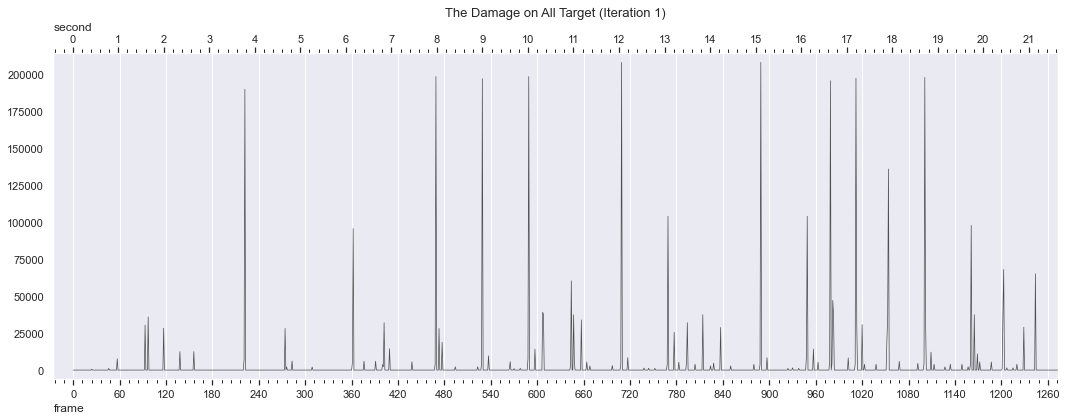

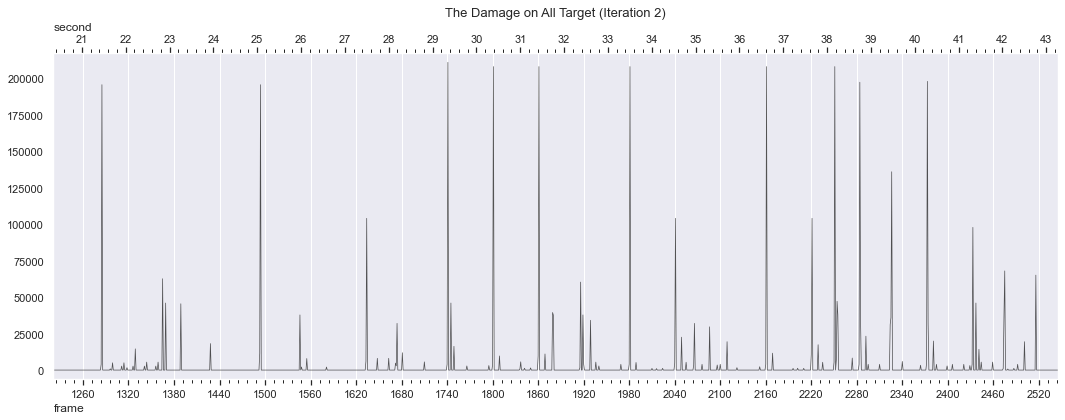

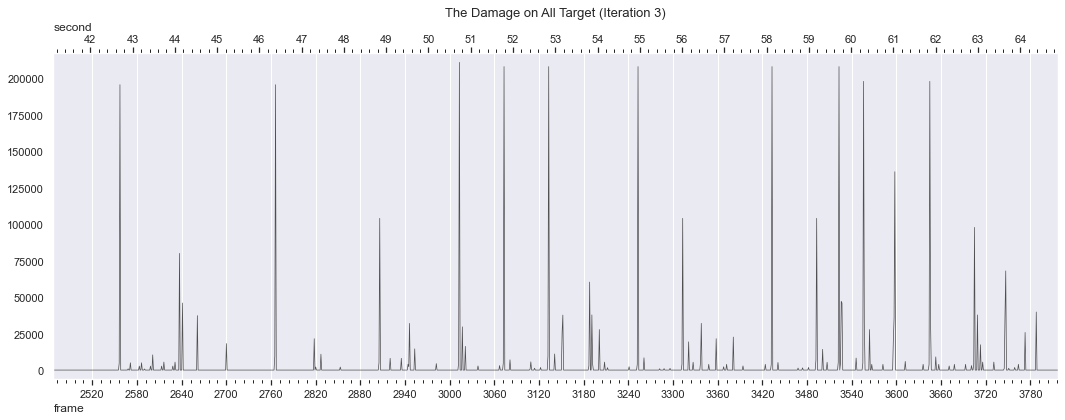

In [27]:
fig_total_damage0 = get_total_damage(the_iteration=0, the_target=0)
fig_total_damage1 = get_total_damage(the_iteration=1, the_target=0)
fig_total_damage2 = get_total_damage(the_iteration=2, the_target=0)

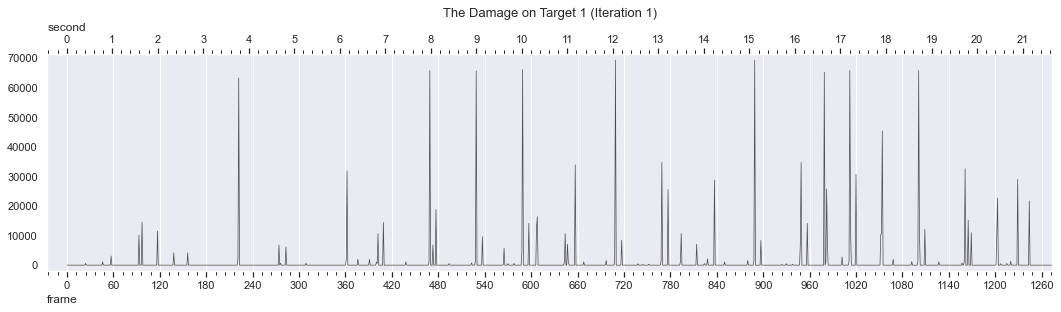

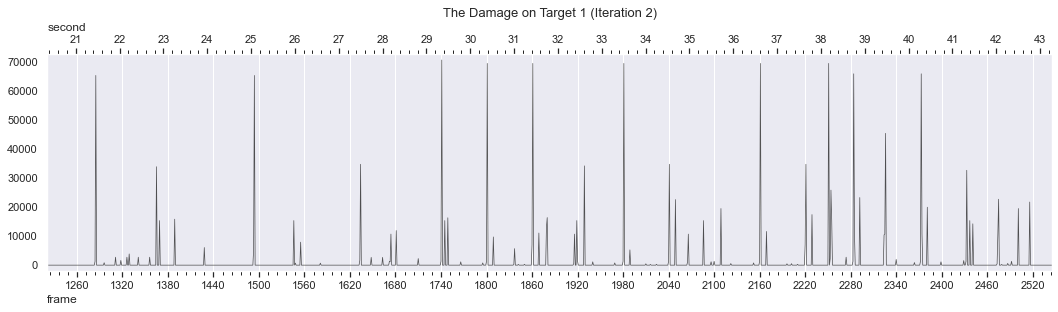

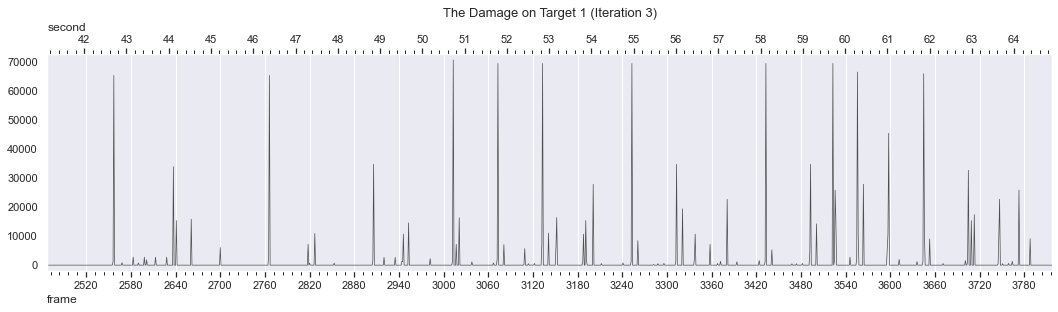

In [28]:
fig_target1_damage0 = get_total_damage(the_iteration=0, the_target=1)
fig_target1_damage1 = get_total_damage(the_iteration=1, the_target=1)
fig_target1_damage2 = get_total_damage(the_iteration=2, the_target=1)

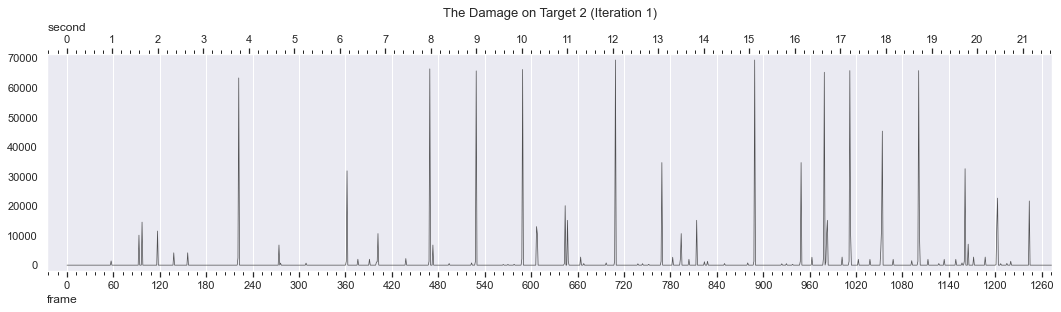

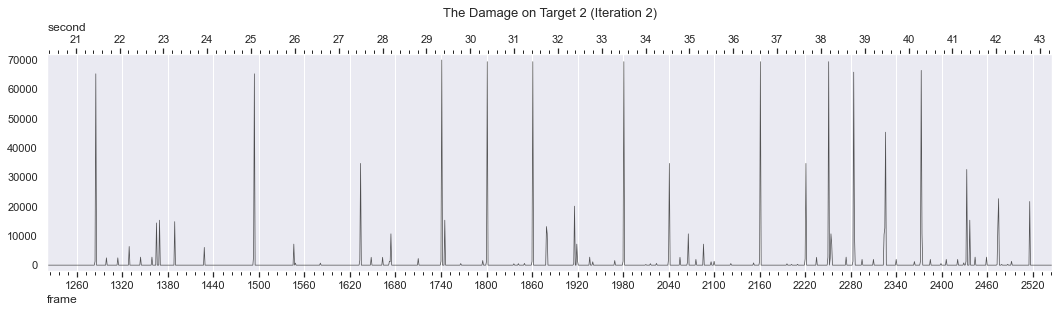

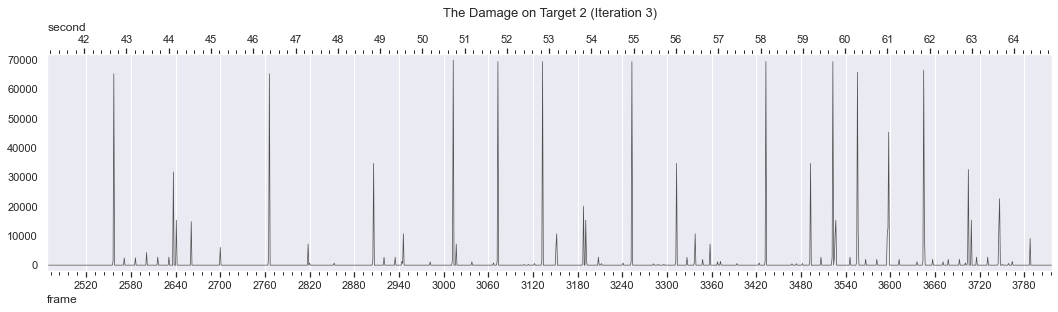

In [29]:
fig_target1_damage0 = get_total_damage(the_iteration=0, the_target=2)
fig_target1_damage1 = get_total_damage(the_iteration=1, the_target=2)
fig_target1_damage2 = get_total_damage(the_iteration=2, the_target=2)

In [30]:
# figure of damage

def get_hurt(the_iteration):
    
    df_tmp = df_expected_damage_all[df_expected_damage_all["iteration"]==the_iteration].groupby(['frame']).agg(
    {"expected_hurt": "sum", "hurt_type": "first"})
    df_tmp = df_tmp.reindex(range(10*loop_frame_len), fill_value=None)
    df_tmp = df_tmp.reset_index(drop=False)
    df_tmp = df_tmp.fillna({"expected_hurt":0, "hurt_type":""})        

    sns.set(style="darkgrid", palette="muted", color_codes=True)
    fig, ax = plt.subplots(figsize=(18,4))

    x_values = df_tmp["frame"]
    y_values = df_tmp["expected_hurt"]
    texts = df_tmp["hurt_type"]

    ax.plot(x_values, y_values, linewidth=0.7, color='k', alpha=0.75) # , '--'

    # set x/y range
    the_ymin = y_values.min()
    the_xmin = the_iteration * loop_frame_len
    the_xmax = (the_iteration+1) * loop_frame_len + 1
    ax.set_ylim(the_ymin*1.03, -the_ymin*0.03)
    ax.set_xlim(the_xmin-the_xmax*0.02, the_xmax*1)

    ax1 = ax.twiny()
    the_xmin1 = the_xmin/60
    the_xmax1 = the_xmax/60
    ax1.set_xlim(the_xmin1-the_xmax1*0.02, the_xmax1*1.02)

    # same grid
    ax1.set_xticks([ idx * the_xmax1 / the_xmax for idx in ax.get_xticks()[1:-1]])
    ax1.grid(None)

    ax.yaxis.grid(False)

    ax.set_xlabel('frame', horizontalalignment='left', x=0)
    ax1.set_xlabel('second', horizontalalignment='left', x=0)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(12))

    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    
    # texts
    for i, txt in enumerate(texts):
        ax.annotate(txt, xy=(x_values[i], the_ymin*1.2), annotation_clip=False, rotation=90, ha="right", va="top")
    
    
    ax.set_title("The Hurt on Characters (Iteration %d)" % (the_iteration+1), fontsize = 13)
    
    return fig

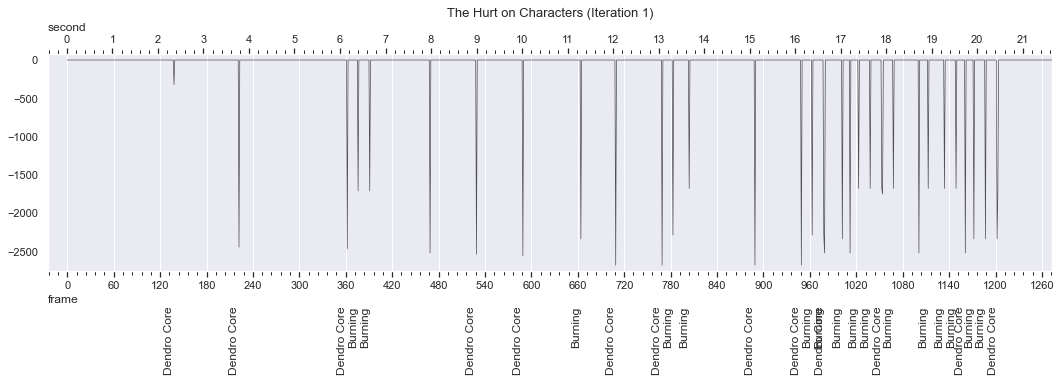

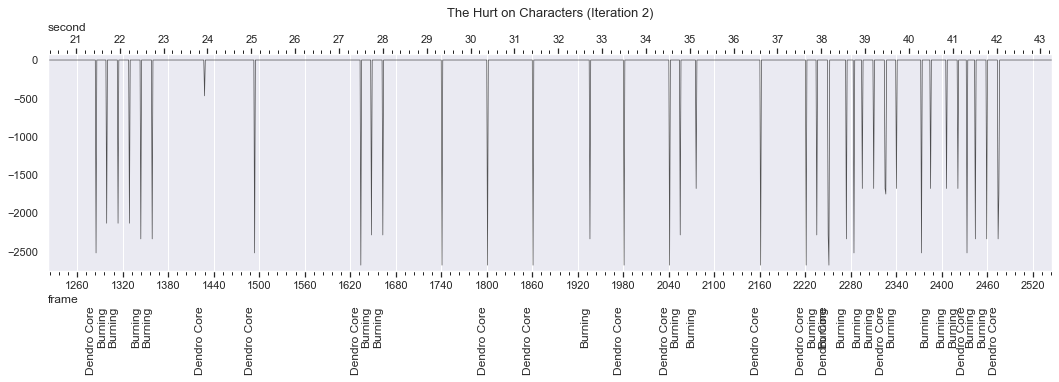

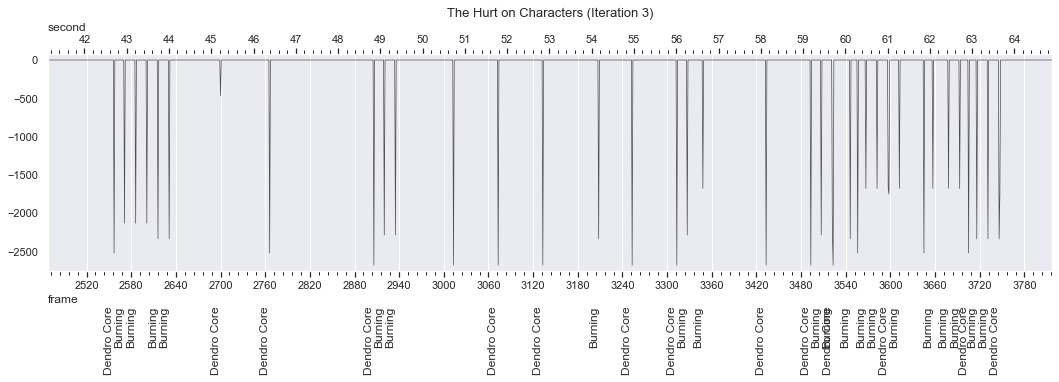

In [31]:
fig_target1_damage0 = get_hurt(the_iteration=0)
fig_target1_damage1 = get_hurt(the_iteration=1)
fig_target1_damage2 = get_hurt(the_iteration=2)

In [32]:
data.keys()

dict_keys(['v2', 'version', 'build_date', 'is_damage_mode', 'active_char', 'char_names', 'damage_by_char', 'damage_instances_by_char', 'damage_by_char_by_targets', 'char_active_time', 'abil_usage_count_by_char', 'particle_count', 'reactions_triggered', 'ele_uptime', 'required_er', 'sim_duration', 'damage', 'dps', 'dps_by_target', 'damage_over_time', 'iter', 'runtime', 'num_targets', 'char_details', 'target_details', 'config_file', 'text', 'debug'])

# 3 hp and shield

In [33]:
# get shield event

list_of_shields = [{"frame":0, "name":"", "shield":0, "expiry":-1}]

for v in data["debug"]:
    
    if v["event"] == "shield":
        
        tmp = {
            "frame": v["frame"],
            "name": v["logs"]["name"],
            "shield": v["logs"]["hp"],
            "expiry": v["logs"]["expiry"],
        }
        
        list_of_shields.append(tmp)

In [34]:
df_shields = pd.DataFrame(list_of_shields) 

In [35]:
df_shields["max_shield"] = df_shields.iloc[-1]["shield"]

df_shields["adding"] = 0  
df_shields.loc[ (df_shields["name"] == "Thoma Skill"), "adding"] = df_shields.iloc[1]["shield"]
df_shields.loc[ (df_shields["name"] == "Thoma Burst"), "adding"] = df_shields.iloc[2]["shield"] - df_shields.iloc[1]["shield"]

In [36]:
df_shields

,frame,name,shield,expiry,max_shield,adding
0,0,,0.000000,-1,11353.042858,0.000000
1,220,Thoma Skill,4170.587172,700,11353.042858,4170.587172
2,401,Thoma Burst,4833.711104,881,11353.042858,663.123932
3,469,Thoma Burst,5496.835037,949,11353.042858,663.123932
4,529,Thoma Burst,6159.958969,1009,11353.042858,663.123932
...,...,...,...,...,...,...
155,12397,Thoma Burst,11353.042858,12877,11353.042858,663.123932
156,12460,Thoma Burst,11353.042858,12940,11353.042858,663.123932
157,12549,Thoma Burst,11353.042858,13029,11353.042858,663.123932
158,12609,Thoma Burst,11353.042858,13089,11353.042858,663.123932


In [37]:
df_hurt = df_expected_damage_all[df_expected_damage_all["expected_hurt"]<0][
    ["frame", "expected_hurt", "hurt_type"]].groupby(['frame']).agg(
    {"expected_hurt": "sum", "hurt_type": "first"})
df_hurt = df_hurt.reset_index(drop=False)

# 对火元素伤害有250%的吸收效果；

df_hurt["discount"] = 1
df_hurt.loc[ (df_hurt["hurt_type"] == "Burning"), "discount"] = 1 / 2.5
df_hurt

,frame,expected_hurt,hurt_type,discount
0,138,-322.425030,Dendro Core,1.0
1,222,-2446.145654,Dendro Core,1.0
2,362,-2464.593036,Dendro Core,1.0
3,376,-1710.089409,Burning,0.4
4,391,-1710.089409,Burning,0.4
...,...,...,...,...
389,12609,-2520.545722,Dendro Core,1.0
390,12620,-2337.377088,Burning,0.4
391,12635,-2337.377088,Burning,0.4
392,12650,-2337.377088,Burning,0.4


In [38]:
df1 = df_shields[["frame", "name", "adding", "max_shield"]]
df2 = df_hurt[["frame", "hurt_type", "expected_hurt", "discount"]]

df1.to_csv('shield.csv', index=False)
df2.to_csv('hurt.csv', index=False)

In [39]:

# 护盾剩余的伤害吸收量在获取新的烈烧佑命护盾时将会叠加，并刷新持续时间。



In [ ]:
# get hp of each chars and shield

data["debug"][:10]